In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

2024-04-24 05:00:16.000463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 05:00:16.000560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 05:00:16.129812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
dataset_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [7]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")    # Convert grayscale to RGB
            image = image.resize((256, 256))  # Resize images to 256x256 pixels
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

In [8]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)

In [9]:
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [10]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [8]:
type(images)

list

In [9]:
len(images)

4200

In [11]:
images = np.array(images)
labels = np.array(labels)

In [12]:
df1=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-shenzhen/shenzhen_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-shenzhen/images/images/'
df1['equalized_filename'] = df1['study_id'].apply(lambda x: base_path+x)
df2=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-montgomery/montgomery_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-montgomery/images/images/'
df2['equalized_filename'] = df2['study_id'].apply(lambda x: base_path+x)
df=pd.concat([df1, df2], ignore_index=True)
df['target']=df['findings'].apply(lambda x:0 if x=='normal' else 1)
df['target'] = df['target'].astype(str)
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
def preprocess_images_cxr(image_dir):
    images = []
    for filename in image_dir:
        image = Image.open(filename)
        image = image.convert("RGB")    # Convert grayscale to RGB
        image = image.resize((256, 256))  # Resize images to 256x256 pixels
        image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
        images.append(image)
    return images

In [14]:
tuberculosis_images_new = preprocess_images_cxr(df['equalized_filename'])


In [15]:
tuberculosis_labels_new= df['target'].values

In [16]:
new_images=np.array(tuberculosis_images_new)
new_labels=np.array(tuberculosis_labels_new)

In [16]:
labels.shape

(4200,)

In [17]:
new_labels.shape

(800,)

In [18]:
new_images.shape

(800, 256, 256, 3)

In [17]:
images= np.concatenate((images, new_images), axis=0)
images.shape

(5000, 256, 256, 3)

In [18]:
labels=np.concatenate((labels,new_labels),axis=0)
labels.shape

(5000,)

In [21]:
type(labels[0])

int

In [22]:
type(labels[4569])

str

In [19]:
labels=labels.astype(int)

In [20]:
images, new_images, labels, new_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [25]:
# # Check the shape of the training and testing sets
# print("Train images shape:", len(train_images))
# print("Test images shape:", len(test_images))
# print("Train labels shape:", len(train_labels))
# print("Test labels shape:", len(test_labels))

In [26]:
# train_images.shape

In [21]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [28]:
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input

from tensorflow.keras.optimizers import Adam


base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])



16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)    │ (None, 8, 8, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,757 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,564 (15.45 MB)

In [30]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  2/125 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.3047 - loss: 0.7442    

I0000 00:00:1713858749.411975      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713858749.460452      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8300 - loss: 0.3919

W0000 00:00:1713858762.803021      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.8305 - loss: 0.3910 - val_accuracy: 0.9410 - val_loss: 0.1744
Epoch 2/10
  2/125 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8516 - loss: 0.2419  

W0000 00:00:1713858770.877189      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9315 - loss: 0.1749 - val_accuracy: 0.9650 - val_loss: 0.1227
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9576 - loss: 0.1168 - val_accuracy: 0.9530 - val_loss: 0.1207
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9607 - loss: 0.1102 - val_accuracy: 0.9640 - val_loss: 0.0958
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9574 - loss: 0.1104 - val_accuracy: 0.9670 - val_loss: 0.0892
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9657 - loss: 0.0900 - val_accuracy: 0.9590 - val_loss: 0.1073
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9661 - loss: 0.0866 - val_accuracy: 0.9660 - val_loss: 0.0921
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9759 - loss: 0.0723 - val_accuracy: 0.9690 - val_loss: 0.0881
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9705 - loss: 0.0792 - val_accuracy: 0.975

In [31]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9647 - loss: 0.1020
Test Loss: 0.09318506717681885
Test Accuracy: 0.9670000076293945


In [32]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

W0000 00:00:1713858847.077252      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step


W0000 00:00:1713858853.613074      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [33]:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       781
           1       0.91      0.95      0.93       219

    accuracy                           0.97      1000
   macro avg       0.95      0.96      0.95      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix:
[[760  21]
 [ 12 207]]


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

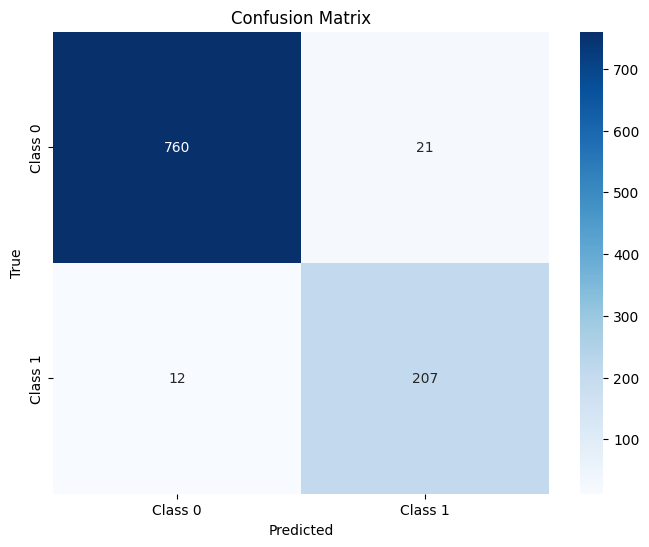

In [35]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
base_model = tf.keras.applications.ConvNeXtSmall(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])


In [47]:
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_small (Functional)     │ (None, 8, 8, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,651,809 (189.41 MB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 49,454,688 (188.65 MB)

In [38]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10


W0000 00:00:1713859238.423260      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859238.423626      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859238.424162      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7748 - loss: 0.5694

W0000 00:00:1713859280.678664      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859280.679122      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859280.679589      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 450ms/step - accuracy: 0.7749 - loss: 0.5692 - val_accuracy: 0.7810 - val_loss: 0.5632
Epoch 2/10


W0000 00:00:1713859294.382905      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.383292      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.383674      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.384746      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.385168      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.385537      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.385916      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859294.386328      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - accuracy: 0.7792 - loss: 0.5336 - val_accuracy: 0.7810 - val_loss: 0.5177
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - accuracy: 0.7666 - loss: 0.5488 - val_accuracy: 0.7810 - val_loss: 0.5188
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 323ms/step - accuracy: 0.7673 - loss: 0.5339 - val_accuracy: 0.7810 - val_loss: 0.6132
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 323ms/step - accuracy: 0.7819 - loss: 0.5356 - val_accuracy: 0.7830 - val_loss: 0.5366
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step - accuracy: 0.7785 - loss: 0.5105 - val_accuracy: 0.7810 - val_loss: 0.5081
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.7900 - loss: 0.4915 - val_accuracy: 0.7870 - val_loss: 0.5414
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 323ms/step - accuracy: 0.7840 - loss: 0.5097 - val_accuracy: 0.7810 - val_loss: 0.5029
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 323ms/step - accuracy: 0.7949 - loss: 0.4929 - val

In [39]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.7583 - loss: 0.5234
Test Loss: 0.49253445863723755
Test Accuracy: 0.7799999713897705


In [40]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 3:22 7s/step

W0000 00:00:1713859702.664171      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859702.664546      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859702.665052      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step


W0000 00:00:1713859716.888952      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.889446      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.889884      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.890952      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.891345      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.891769      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.892173      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713859716.892538      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [41]:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       781
           1       0.40      0.01      0.02       219

    accuracy                           0.78      1000
   macro avg       0.59      0.50      0.45      1000
weighted avg       0.70      0.78      0.69      1000

Confusion Matrix:
[[778   3]
 [217   2]]


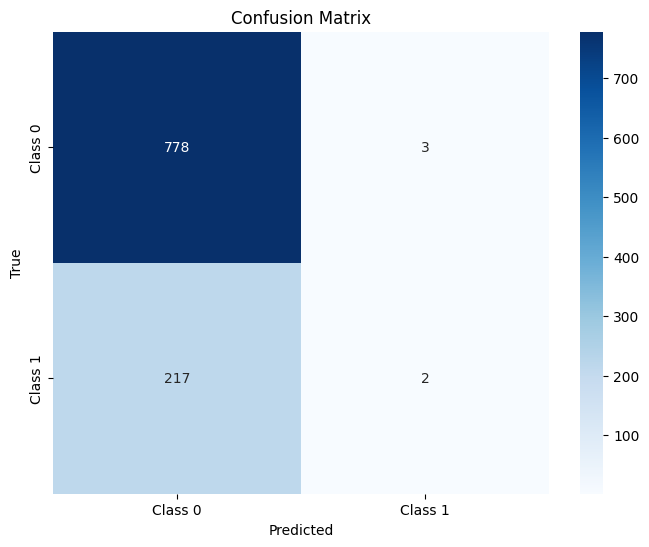

In [42]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input

from tensorflow.keras.optimizers import Adam

In [23]:
base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False



# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])


In [24]:
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 8, 8, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,017,249 (106.88 MB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [25]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10


I0000 00:00:1713862259.999204     591 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713862260.034140     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862260.034895     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862260.035614     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7424 - loss: 0.6311

W0000 00:00:1713862283.657196     588 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862283.657543     588 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862283.657926     588 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 260ms/step - accuracy: 0.7427 - loss: 0.6305 - val_accuracy: 0.7810 - val_loss: 0.5280
Epoch 2/10


W0000 00:00:1713862292.448574     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.449095     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.449556     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.450537     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.450937     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.451333     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.451719     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862292.452116     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.7749 - loss: 0.5383 - val_accuracy: 0.7810 - val_loss: 0.5175
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.7724 - loss: 0.5338 - val_accuracy: 0.7810 - val_loss: 0.5657
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.7769 - loss: 0.5420 - val_accuracy: 0.7810 - val_loss: 0.5123
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - accuracy: 0.7794 - loss: 0.5193 - val_accuracy: 0.7810 - val_loss: 0.5091
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.7826 - loss: 0.5128 - val_accuracy: 0.7820 - val_loss: 0.5119
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.7817 - loss: 0.5081 - val_accuracy: 0.7810 - val_loss: 0.5130
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.7791 - loss: 0.5085 - val_accuracy: 0.7810 - val_loss: 0.5871
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.7791 - loss: 0.5172 - val

In [26]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7594 - loss: 0.5391
Test Loss: 0.5027734041213989
Test Accuracy: 0.7820000052452087


In [27]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

 2/32 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step

W0000 00:00:1713862530.314187     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862530.314538     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862530.314967     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step


W0000 00:00:1713862538.499466     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.499968     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.500408     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.501376     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.501781     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.502162     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.502525     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713862538.502903     591 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [28]:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       781
           1       0.67      0.01      0.02       219

    accuracy                           0.78      1000
   macro avg       0.72      0.50      0.45      1000
weighted avg       0.76      0.78      0.69      1000

Confusion Matrix:
[[780   1]
 [217   2]]


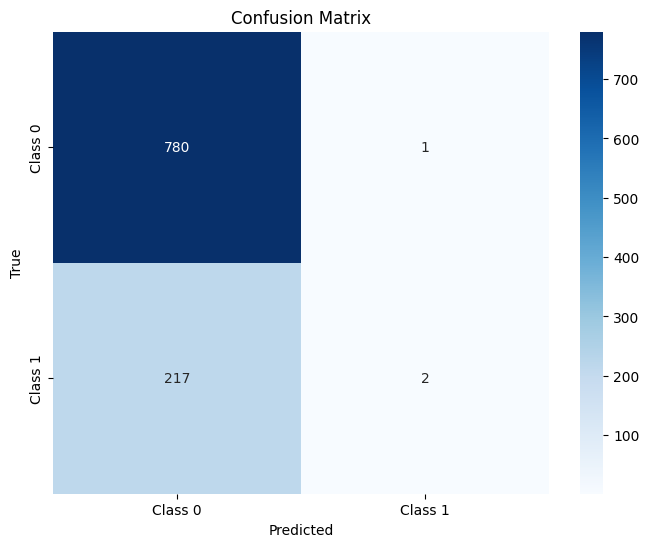

In [29]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input

from tensorflow.keras.optimizers import Adam


base_model = efn.EfficientNetB1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])



27164032/27164032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b1 (Functional)    │ (None, 8, 8, 1280)     │     6,575,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,903,425 (26.33 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 6,575,232 (25.08 MB)

In [25]:
history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  3/125 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8108 - loss: 0.5726   

I0000 00:00:1713867535.085738     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 196ms/step - accuracy: 0.8914 - loss: 0.2747 - val_accuracy: 0.9450 - val_loss: 0.1666
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9346 - loss: 0.1679 - val_accuracy: 0.9560 - val_loss: 0.1224
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9391 - loss: 0.1493 - val_accuracy: 0.9590 - val_loss: 0.1092
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9579 - loss: 0.1139 - val_accuracy: 0.9680 - val_loss: 0.0984
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9540 - loss: 0.1112 - val_accuracy: 0.9710 - val_loss: 0.0930
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9590 - loss: 0.0969 - val_accuracy: 0.9730 - val_loss: 0.0807
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9615 - loss: 0.0917 - val_accuracy: 0.9710 - val_loss: 0.0880
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9679 - loss: 0.0858 - val_accuracy: 0.9

In [31]:
images.shape

(3200, 256, 256, 3)

In [26]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9513 - loss: 0.1194
Test Loss: 0.10766945779323578
Test Accuracy: 0.953000009059906


In [27]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step


In [28]:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       781
           1       0.85      0.95      0.90       219

    accuracy                           0.95      1000
   macro avg       0.92      0.95      0.93      1000
weighted avg       0.96      0.95      0.95      1000

Confusion Matrix:
[[744  37]
 [ 10 209]]


In [30]:
import seaborn as sns

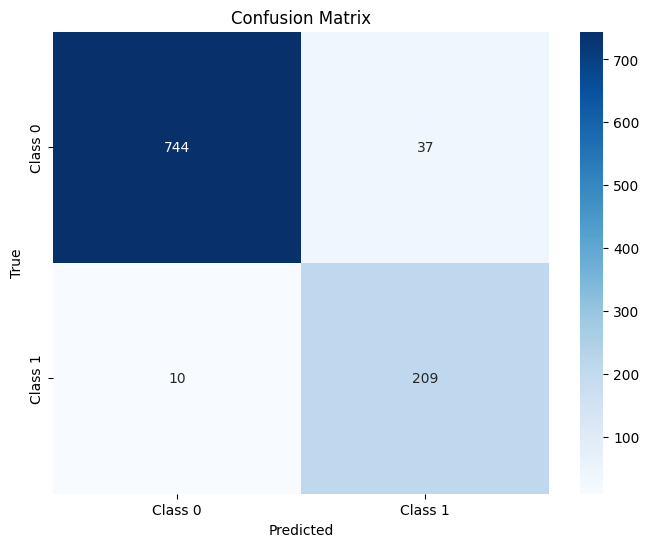

In [31]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
base_model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])

model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()







Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b2 (Functional)    │ (None, 8, 8, 1408)     │     7,768,562 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129,523 (31.01 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 7,768,562 (29.63 MB)

In [22]:

history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  3/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6337 - loss: 0.6532   

I0000 00:00:1713868311.855819     432 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 199ms/step - accuracy: 0.8601 - loss: 0.3369 - val_accuracy: 0.9170 - val_loss: 0.1677
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9346 - loss: 0.1571 - val_accuracy: 0.9340 - val_loss: 0.1448
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9399 - loss: 0.1430 - val_accuracy: 0.9610 - val_loss: 0.1046
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9483 - loss: 0.1261 - val_accuracy: 0.9530 - val_loss: 0.1086
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9591 - loss: 0.1019 - val_accuracy: 0.9650 - val_loss: 0.0956
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9592 - loss: 0.1014 - val_accuracy: 0.9590 - val_loss: 0.1123
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9550 - loss: 0.1118 - val_accuracy: 0.9740 - val_loss: 0.0801
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9684 - loss: 0.0843 - val_accuracy: 0.9

In [23]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9742 - loss: 0.0693
Test Loss: 0.0693126693367958
Test Accuracy: 0.9760000109672546


In [26]:
#add Codeadd Markdown
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       781
           1       0.95      0.94      0.94       219

    accuracy                           0.98      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.98      0.98      0.98      1000



In [27]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed


Confusion Matrix:
[[771  10]
 [ 14 205]]


In [20]:
import seaborn as sns

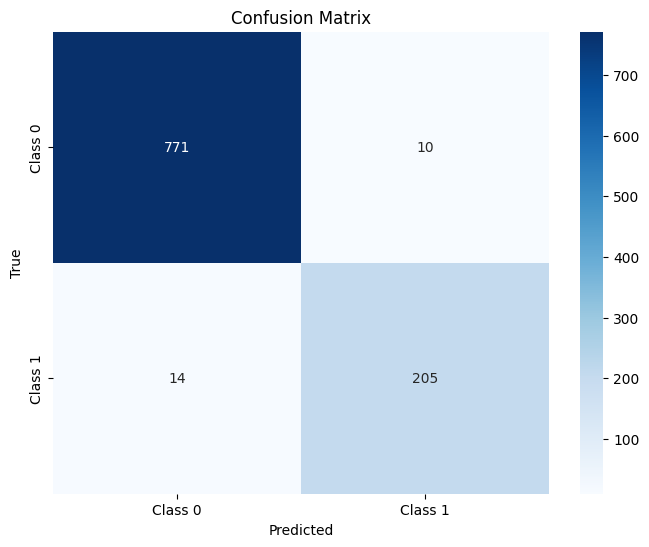

In [30]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])

model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()







44107200/44107200 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b3 (Functional)    │ (None, 8, 8, 1536)     │    10,783,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,257 (42.64 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 10,783,528 (41.14 MB)

In [32]:

history = model.fit(images, labels,
                          epochs=15,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 228ms/step - accuracy: 0.8424 - loss: 0.3821 - val_accuracy: 0.9370 - val_loss: 0.1461
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9290 - loss: 0.1669 - val_accuracy: 0.9520 - val_loss: 0.1309
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9327 - loss: 0.1709 - val_accuracy: 0.9610 - val_loss: 0.1000
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9527 - loss: 0.1280 - val_accuracy: 0.9640 - val_loss: 0.0935
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9474 - loss: 0.1284 - val_accuracy: 0.9630 - val_loss: 0.0887
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9503 - loss: 0.1197 - val_accuracy: 0.9690 - val_loss: 0.0789
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9646 - loss: 0.1107 - val_accuracy: 0.9610 - val_loss: 0.0886
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9613 - loss: 0.1004 -

In [33]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9655 - loss: 0.0817
Test Loss: 0.08569839596748352
Test Accuracy: 0.9610000252723694


In [34]:
#add Codeadd Markdown
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       781
           1       0.90      0.93      0.91       219

    accuracy                           0.96      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.96      0.96      0.96      1000



In [35]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed


Confusion Matrix:
[[758  23]
 [ 16 203]]


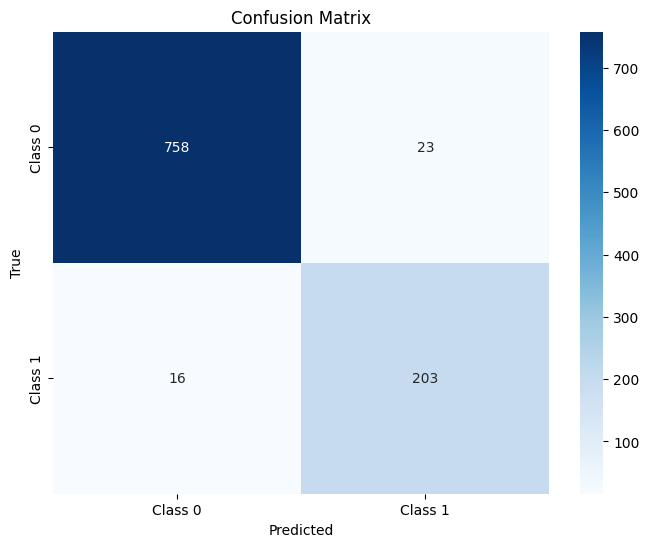

In [36]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])

model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()







71892840/71892840 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b4 (Functional)    │ (None, 8, 8, 1792)     │    17,673,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,133,081 (69.17 MB)

 Trainable params: 459,265 (1.75 MB)

 Non-trainable params: 17,673,816 (67.42 MB)

In [22]:

history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 2:18:33 67s/step - accuracy: 0.2188 - loss: 0.7811

I0000 00:00:1713869910.984395     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 267ms/step - accuracy: 0.8485 - loss: 0.3361 - val_accuracy: 0.9430 - val_loss: 0.1599
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9204 - loss: 0.1970 - val_accuracy: 0.9450 - val_loss: 0.1439
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9425 - loss: 0.1517 - val_accuracy: 0.9500 - val_loss: 0.1279
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9383 - loss: 0.1585 - val_accuracy: 0.9490 - val_loss: 0.1364
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.9472 - loss: 0.1373 - val_accuracy: 0.9580 - val_loss: 0.1144
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9456 - loss: 0.1339 - val_accuracy: 0.9630 - val_loss: 0.1070
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9478 - loss: 0.1288 - val_accuracy: 0.9600 - val_loss: 0.0976
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.9514 - loss: 0.1161 - va

In [23]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9645 - loss: 0.0899
Test Loss: 0.0998167023062706
Test Accuracy: 0.9610000252723694


In [24]:
#add Codeadd Markdown
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       781
           1       0.97      0.85      0.91       219

    accuracy                           0.96      1000
   macro avg       0.96      0.92      0.94      1000
weighted avg       0.96      0.96      0.96      1000



In [25]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed


Confusion Matrix:
[[775   6]
 [ 33 186]]


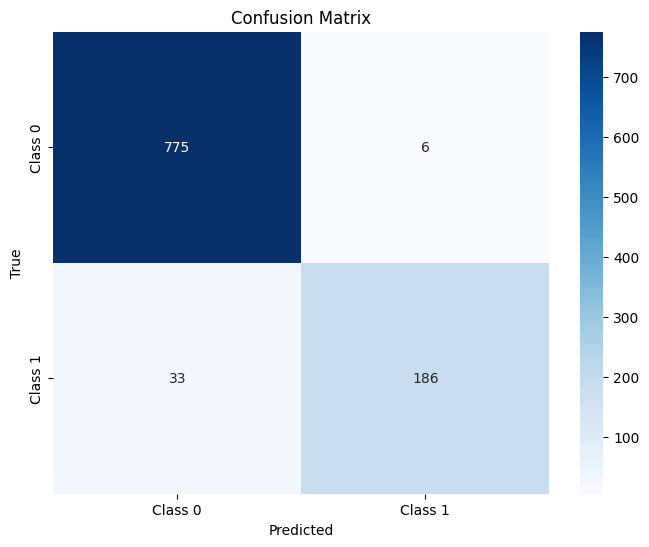

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])

model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()







115515256/115515256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b5 (Functional)    │ (None, 8, 8, 2048)     │    28,513,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,038,321 (110.77 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 28,513,520 (108.77 MB)

In [23]:

history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 2:58:48 87s/step - accuracy: 0.3125 - loss: 0.7413

I0000 00:00:1713871120.364879     488 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713871120.472404     488 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8297 - loss: 0.3759

W0000 00:00:1713871148.568996     488 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 327ms/step - accuracy: 0.8301 - loss: 0.3752 - val_accuracy: 0.9260 - val_loss: 0.1792
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9071 - loss: 0.2186 - val_accuracy: 0.9490 - val_loss: 0.1437
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9295 - loss: 0.1714 - val_accuracy: 0.9430 - val_loss: 0.1592
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9409 - loss: 0.1548 - val_accuracy: 0.9490 - val_loss: 0.1258
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9501 - loss: 0.1246 - val_accuracy: 0.9510 - val_loss: 0.1262
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9448 - loss: 0.1418 - val_accuracy: 0.9560 - val_loss: 0.1122
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9518 - loss: 0.1240 - val_accuracy: 0.9550 - val_loss: 0.1261
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9557 - loss: 0.1114 - va

In [24]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9586 - loss: 0.1019
Test Loss: 0.10616713762283325
Test Accuracy: 0.9589999914169312


In [25]:
#add Codeadd Markdown
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)


 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step

W0000 00:00:1713871340.030382     488 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 467ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       781
           1       0.90      0.91      0.91       219

    accuracy                           0.96      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.96      0.96      0.96      1000



In [26]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed


Confusion Matrix:
[[760  21]
 [ 20 199]]


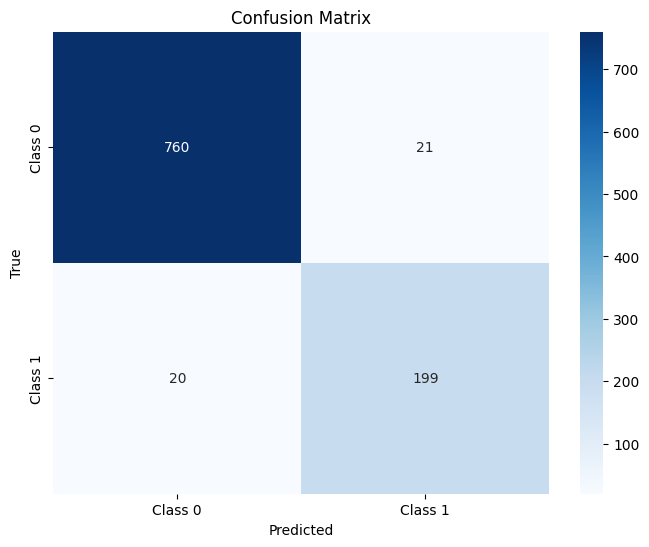

In [27]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False



# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b6 (Functional)    │ (None, 8, 8, 2304)     │    40,960,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2304)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,550,473 (158.50 MB)

 Trainable params: 590,337 (2.25 MB)

 Non-trainable params: 40,960,136 (156.25 MB)

In [24]:

history = model.fit(images, labels,
                          epochs=10,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/10


I0000 00:00:1713932816.464020     160 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713932816.596008     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8315 - loss: 0.3793

W0000 00:00:1713932849.766622     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 149s 391ms/step - accuracy: 0.8319 - loss: 0.3787 - val_accuracy: 0.9100 - val_loss: 0.2139
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.9104 - loss: 0.2258 - val_accuracy: 0.9310 - val_loss: 0.1763
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9127 - loss: 0.2102 - val_accuracy: 0.9370 - val_loss: 0.1508
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9222 - loss: 0.1831 - val_accuracy: 0.9430 - val_loss: 0.1454
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9293 - loss: 0.1840 - val_accuracy: 0.9510 - val_loss: 0.1210
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9426 - loss: 0.1552 - val_accuracy: 0.9500 - val_loss: 0.1290
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.9451 - loss: 0.1456 - val_accuracy: 0.9480 - val_loss: 0.1324
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.9442 - loss: 0.1400 - va

In [25]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9480 - loss: 0.1177
Test Loss: 0.12661384046077728
Test Accuracy: 0.9480000138282776


In [26]:
#add Codeadd Markdown
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)


 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step 

W0000 00:00:1713933263.106242     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 538ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       781
           1       0.87      0.90      0.88       219

    accuracy                           0.95      1000
   macro avg       0.92      0.93      0.92      1000
weighted avg       0.95      0.95      0.95      1000



In [27]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed


Confusion Matrix:
[[751  30]
 [ 22 197]]


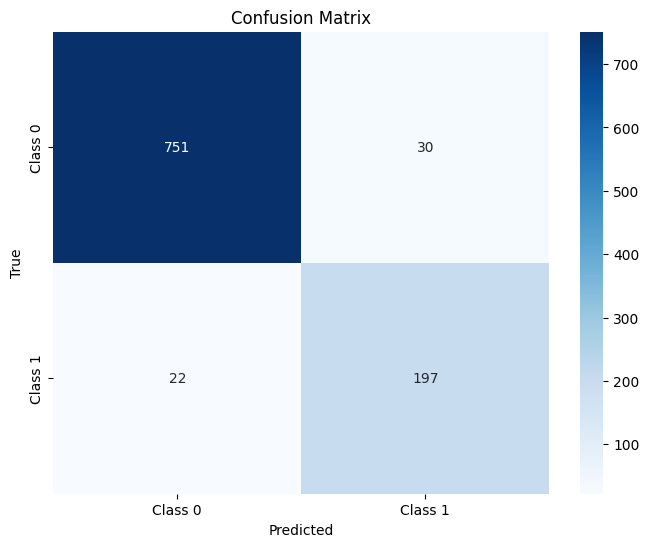

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False



# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Change the number of units according to your task
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()




258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b7 (Functional)    │ (None, 8, 8, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,753,553 (247.02 MB)

 Trainable params: 655,873 (2.50 MB)

 Non-trainable params: 64,097,680 (244.51 MB)

In [25]:

history = model.fit(images, labels,
                          epochs=20,
                          batch_size=32,
                          validation_data=(new_images, new_labels))

Epoch 1/20


I0000 00:00:1713935277.524629     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713935277.677792     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8117 - loss: 0.4368

W0000 00:00:1713935318.801649     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 179s 467ms/step - accuracy: 0.8121 - loss: 0.4361 - val_accuracy: 0.9280 - val_loss: 0.1780
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - accuracy: 0.8987 - loss: 0.2524 - val_accuracy: 0.9370 - val_loss: 0.1511
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 243ms/step - accuracy: 0.9017 - loss: 0.2402 - val_accuracy: 0.9510 - val_loss: 0.1412
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 243ms/step - accuracy: 0.9215 - loss: 0.1970 - val_accuracy: 0.9350 - val_loss: 0.1373
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - accuracy: 0.9179 - loss: 0.2136 - val_accuracy: 0.9450 - val_loss: 0.1346
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.9152 - loss: 0.2169 - val_accuracy: 0.9410 - val_loss: 0.1450
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - accuracy: 0.9122 - loss: 0.2167 - val_accuracy: 0.9540 - val_loss: 0.1165
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.9216 - loss: 0.1800 - va

In [26]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9575 - loss: 0.1084
Test Loss: 0.10034308582544327
Test Accuracy: 0.9610000252723694


In [27]:
#add Codeadd Markdown
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)

classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)


 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step

W0000 00:00:1713935954.907552     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       781
           1       0.91      0.92      0.91       219

    accuracy                           0.96      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.96      0.96      0.96      1000



In [28]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed


Confusion Matrix:
[[760  21]
 [ 18 201]]


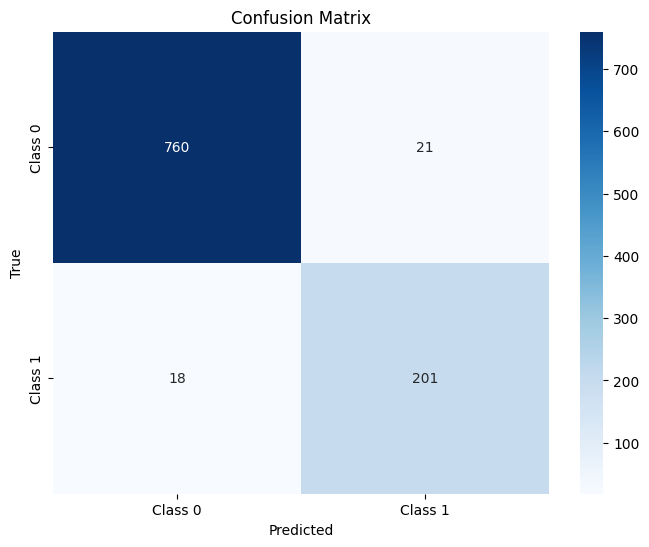

In [29]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()